In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import pickle
import math
import sys
sys.path.append('../gym-flight/')
import gym_flight
from gym_flight.utils.geo import destination
from util import *
import multiprocessing as mp
from full3d_util import get_range_df, bind, unlist
splits = mp.cpu_count() - 1
from aircraft_center_3d_util import train_test_split, fix_XY
import matplotlib.pyplot as plt

In [2]:
half_x_length = 5
half_y_length = 7
half_z_length = 12

In [3]:
if os.path.isfile("processed_flight_data.bin"):
    flight_data = pickle.load(open("processed_flight_data.bin", "rb"))
else:
    if os.path.isfile("raw_flight_data.bin"):
        flight_data = pickle.load(open("raw_flight_data.bin", "rb"))
    else:
        flight_data_path = "../../JFKSamples.csv"
        dtype_dict = {"id": str, "raw_ts": np.int64, "ts": np.int64, "lat": np.float32, "lon": np.float32, "altitude": np.float32, "speed": np.float32, "x": np.int16, "y": np.int16, "z": np.int16, "is_landing": np.int8}
        flight_data = pd.read_csv(flight_data_path, dtype = dtype_dict)
        flight_data = flight_data.sort_values(by = ['id', 'ts']).reset_index(drop = True)
        flight_data = flight_data.drop_duplicates(subset = ['id', 'ts'], keep = 'first')
        flight_data = flight_data.sort_values(by = ['id', 'ts']).reset_index(drop = True)
        temp_ts = (flight_data['ts']/1000).apply(math.floor)
        temp_ts = temp_ts - temp_ts.apply(lambda x: x % 60)
        flight_data['round_min_ts'] = pd.to_datetime(temp_ts, unit = 's')
        flight_data = flight_data.drop_duplicates(subset = ['id', 'ts'], keep = 'first')
        flight_data['raw_ts'] = pd.to_datetime(flight_data['ts']/1000, unit = 's')
        flight_data['prev_ts'] = flight_data[['id', 'raw_ts']].set_index(['id']).groupby(level="id").shift(1).reset_index(drop = True)
        flight_data['prev_time_diff_s'] = flight_data['raw_ts'] - flight_data['prev_ts']
        flight_data['prev_time_diff_s'] = flight_data['prev_time_diff_s'].apply(lambda x: x.delta if type(x) != pd._libs.tslibs.nattype.NaTType else 0)/1000000000
        flight_data = get_new_id_flight_data(flight_data)
        flight_data['time'] = flight_data['raw_ts'].apply(lambda x: x.time())
        flight_data['date'] = flight_data['raw_ts'].apply(lambda x: x.date())
        flight_data['time_diff'] = flight_data['raw_ts'] - flight_data['round_min_ts']
        flight_data['time_diff_s'] = flight_data['time_diff'].apply(lambda x: x.delta)/1000000000
        flight_data['ground_distance'] = flight_data['time_diff_s'] * flight_data['ground_speed'] * 4.63/9
        # Extrapolating (backwards in time) using the first known speed, heading at a given minute
        flight_data['min_start_lat_lon'] = flight_data.apply(lambda row: destination(row['lat'], row['lon'], row['azimuth'], -row['ground_distance']), axis = 1)
        flight_data['min_start_lat'] = flight_data['min_start_lat_lon'].apply(lambda x: x[0])
        flight_data['min_start_lon'] = flight_data['min_start_lat_lon'].apply(lambda x: x[1])
        pickle.dump(flight_data, open("raw_flight_data.bin", "wb"))
    
    flight_data = flight_data.sort_values(by = ['id', 'round_min_ts']).reset_index(drop = False)
    flight_data = flight_data.drop_duplicates(subset = ['id', 'round_min_ts'], keep = 'first')
    flight_data = flight_data.reset_index(drop = True)
    flight_data['next_round_min_ts'] = flight_data[['id', 'round_min_ts']].set_index(['id']).groupby(level="id").shift(-1).reset_index(drop = True)
    flight_data1 = get_timestamps_df(flight_data)
    flight_data1.columns = ['round_min_ts', 'id']
    flight_data = pd.merge(flight_data, flight_data1, how = 'outer')
    flight_data = flight_data.sort_values(by = ['id', 'round_min_ts']).reset_index(drop = True)
    flight_data = flight_data.drop(['index'], axis = 1)
    flight_data = flight_data[['id', 'round_min_ts', 'ground_speed', 'altitude', 'azimuth', 'min_start_lat', 'min_start_lon']]
    flight_data.columns = ['id', 'ts', 'ground_speed', 'altitude', 'azimuth', 'lat', 'lon']
    speeds = flight_data['ground_speed'].tolist()
    alts = flight_data['altitude'].tolist()
    azis = flight_data['azimuth'].tolist()
    lats = flight_data['lat'].tolist()
    lons = flight_data['lon'].tolist()

    for i in range(len(speeds)):
        if np.isnan(speeds[i]):
            speeds[i] = speeds[i-1]
            alts[i] = alts[i-1]
            azis[i] = azis[i-1]
            dist = speeds[i] * 60 * 4.63 / 9
            lat_lon = destination(lats[i-1], lons[i-1], azis[i-1], dist)
            lats[i] = lat_lon[0]
            lons[i] = lat_lon[1]
    
    flight_data['ground_speed'] = speeds
    flight_data['altitude'] = alts
    flight_data['azimuth'] = azis
    flight_data['lon'] = lons
    flight_data['lat'] = lats
    shifted = flight_data.drop('ts', axis = 1).set_index('id').groupby(level = 'id').shift(-1).reset_index(drop = True)
    shifted.columns = ['next_' + col for col in shifted.columns]
    flight_data = pd.concat([flight_data, shifted], axis = 1)
    flight_data['d_speed'] = flight_data['next_ground_speed'] - flight_data['ground_speed']
    flight_data['d_altitude'] = flight_data['next_altitude'] - flight_data['altitude']
    flight_data['d_azimuth'] = flight_data['next_azimuth'] - flight_data['azimuth']
    pickle.dump(flight_data, open("processed_flight_data.bin", "wb"))

In [ ]:
flight_data.shape

In [5]:
flight_data = remove_aircraft_with_anomalous_data(flight_data, speed_at_ground_altitude = True, estimated_speed = False, ground_speed = True, altitude = True)

In [6]:
flight_data['altitude'] = flight_data['altitude'].clip(lower = 0)

In [7]:
flight_data.shape

(352985, 18)

# Important
Do not remove anomalous aircraft. Position estimate can be changed to weighted average of last and next known positions.

# Discretizing

## Discretizing space

Imputation looks ok

In [8]:
lon_min = flight_data['lon'].min()
lon_max = flight_data['lon'].max()
lat_min = flight_data['lat'].min()
lat_max = flight_data['lat'].max()
print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

-81.6034924593011
-64.07259139124781
33.42332498145621
46.41334811983426


In [9]:
flight_data['lat'] = flight_data['lat'].clip(lower = 35)
flight_data['lat'] = flight_data['lat'].clip(upper = 45)
flight_data['lon'] = flight_data['lon'].clip(lower = -78)
flight_data['lon'] = flight_data['lon'].clip(upper = -68)
lon_min = flight_data['lon'].min()
lon_max = flight_data['lon'].max()
lat_min = flight_data['lat'].min()
lat_max = flight_data['lat'].max()
print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

-78.0
-68.0
35.0
45.0


In [10]:
x_length = 100
y_length = 100
z_length = 100
alt_bucket_range = 500 # One bucket every 500 ft

# Matching the schema with the previous preprocessed data - for reusability
flight_data['x'] = (x_length * (flight_data['lat'] - lat_min - 0.0001)/(lat_max - lat_min)).apply(math.ceil)
flight_data['y'] = (y_length * (flight_data['lon'] - lon_min - 0.0001)/(lon_max - lon_min)).apply(math.ceil)
flight_data['z'] = (flight_data['altitude']/alt_bucket_range).apply(math.floor)
flight_data['x'] = flight_data['x'].clip(upper = x_length - 1)
flight_data['y'] = flight_data['y'].clip(upper = y_length - 1)
flight_data['z'] = flight_data['z'].clip(upper = z_length - 1)

## Discretizing time

In [11]:
x = ((flight_data['ts'] - flight_data['ts'].min()).apply(lambda x: x.delta/1000000000)/60).apply(math.floor)
flight_data['ts'] = x

# Making each aircraft as center

In [12]:
def get_X_Y_mp(uniq_ts):
        return get_X_Y(flight_data, uniq_ts)


def get_X_Y(flight_data, uniq_ts, include_controlled_ac = True):
    X = {}
    Y = {}
    for k, ts in enumerate(uniq_ts):
        ts_df = flight_data[flight_data['ts'] == ts]
        if ts_df.shape[0] > 0:
            for i in range(ts_df.shape[0]):
                controlled_ac_row = ts_df.iloc[i]
                controlled_ac_df = np.zeros(tuple(state_dim) + (2, ))
                aircraft_x = controlled_ac_row['x']
                aircraft_y = controlled_ac_row['y']
                aircraft_z = controlled_ac_row['z']
                lower_x = aircraft_x - half_x_length
                upper_x = aircraft_x + half_x_length
                lower_y = aircraft_y - half_y_length
                upper_y = aircraft_y + half_y_length
                lower_z = aircraft_z - half_z_length
                upper_z = aircraft_z + half_z_length
                for j in range(ts_df.shape[0]):
                    if j != i:
                        other_ac_x = ts_df['x'].iloc[j]
                        other_ac_y = ts_df['y'].iloc[j]
                        other_ac_z = ts_df['z'].iloc[j]
                        if other_ac_x >= lower_x and other_ac_x <= upper_x and other_ac_y >= lower_y and other_ac_y <= upper_y and other_ac_z >= lower_z and other_ac_z <= upper_z:
                            controlled_ac_df[other_ac_x - lower_x, other_ac_y - lower_y, other_ac_z - lower_z, :] = [ts_df['ground_speed'].iloc[j], ts_df['azimuth'].iloc[j]]

                if include_controlled_ac:
                    controlled_ac_df[half_x_length, half_y_length, half_z_length, :] = [controlled_ac_row['ground_speed'], controlled_ac_row['azimuth']]

                X[(ts, controlled_ac_row['id'])] = controlled_ac_df
                Y[(ts, controlled_ac_row['id'])] = np.array([controlled_ac_row['next_ground_speed'] - controlled_ac_row['ground_speed'], controlled_ac_row['next_altitude'] - controlled_ac_row['altitude'], controlled_ac_row['next_azimuth'] - controlled_ac_row['azimuth']])
    
    return X, Y



if os.path.isfile("Y_train_aircraft_center_space_continuous_action_new_preprocessing.npy"):
    X_train = np.load("X_train_aircraft_center_space_multiclass_action_new_preprocessing.npy")
    Y_train = np.load("Y_train_aircraft_center_space_continuous_action_new_preprocessing.npy")
    X_test = np.load("X_test_aircraft_center_space_multiclass_action_new_preprocessing.npy")
    Y_test = np.load("Y_test_aircraft_center_space_continuous_action_new_preprocessing.npy")
    y_min = np.load("y_min.npy")
    y_max = np.load("y_max.npy")
else:
    uniq_ts = flight_data['ts'].unique()
    uniq_ts.sort()
    state_dim = [2 * half_x_length + 1, 2 * half_y_length + 1, 2 * half_z_length + 1]
    p = mp.Pool(processes = splits)
    
    # Arranging in reverse order to speed up computation
    rng = list(uniq_ts)
    # Multiprocessing the generation of examples from raw data
    split_rng = np.array_split(rng, splits)
    pool_results = p.map(get_X_Y_mp, split_rng)
    p.close()
    p.join()
    XY = np.concatenate(pool_results, axis = 0)
    
    # Arranging X and Y
    X = [XY[i] for i in range(len(XY)) if i % 2 == 0]
    Y = [XY[i] for i in range(len(XY)) if i % 2 == 1]
    X = [np.array([item.reshape(8250) for item in list(x.values())]) for x in X]
    Y = [np.array(list(y.values())) for y in Y]
    X = np.concatenate(X, axis = 0)
    Y = np.concatenate(Y, axis = 0)
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
    
    # Removing rows with nan values
    Y_train_nan = np.isnan(Y_train[:,0])
    Y_train = Y_train[~Y_train_nan, :]
    X_train = X_train[~Y_train_nan, :]
    Y_test_nan = np.isnan(Y_test[:,0])
    Y_test = Y_test[~Y_test_nan, :]
    X_test = X_test[~Y_test_nan, :]
    
    # Normalizing output
    y_train_min = np.min(Y_train, axis = 0)
    y_train_max = np.max(Y_train, axis = 0)
    y_test_min = np.min(Y_test, axis = 0)
    y_test_max = np.max(Y_test, axis = 0)

    y_min = np.array([min(y_train_min[i], y_test_min[i]) for i in range(3)])
    y_max = np.array([max(y_train_max[i], y_test_max[i]) for i in range(3)])

    Y_train = (Y_train - y_min)/(y_max - y_min)
    Y_test = (Y_test - y_min)/(y_max - y_min)
    
    # Saving
    np.save("X_train_aircraft_center_space_multiclass_action_new_preprocessing", X_train)
    np.save("Y_train_aircraft_center_space_continuous_action_new_preprocessing", Y_train)
    np.save("X_test_aircraft_center_space_multiclass_action_new_preprocessing", X_test)
    np.save("Y_test_aircraft_center_space_continuous_action_new_preprocessing", Y_test)
    np.save("y_min", y_min)
    np.save("y_max", y_max)

# Modeling

In [13]:
class MLP_continuous:
    def __init__(self, state_dim, learning_rate):
        self.target_ = tf.placeholder(tf.float32, [None, 3], name='target')
        self.state_ = tf.placeholder(tf.float32, [None, state_dim], name='state')
        self.learning_rate = learning_rate
        
        # fc1: (, 1024)
        self.fc1 = tf.layers.dense(self.state_, 1024, activation=tf.nn.sigmoid, name='fc1')
        
        # Fc2 (b, 128) - may be bottleneck layer because action size is larger
        self.fc2 = tf.layers.dense(self.fc1, 128, activation=tf.nn.sigmoid, name='fc2')
        
        # Split into 3 linear output units for:
        # - change in speed
        # - change in altitude
        # - change in heading
        # This should probably be changed to separate dense 'heads' that connect to individual outputs
        # If we maintain different dense heads, if one output is noisy, then the weights of that dense head will be random (with the hope that weights of other heads are not affected)
        self.fc3_d_speed = tf.layers.dense(self.fc2, 32, activation=tf.nn.sigmoid, name='fc3_d_speed')
        self.fc3_d_altitude = tf.layers.dense(self.fc2, 32, activation=tf.nn.sigmoid, name='fc3_d_altitude')
        self.fc3_d_azimuth = tf.layers.dense(self.fc2, 32, activation=tf.nn.sigmoid, name='fc3_d_azimuth')
        self.output_d_speed = tf.layers.dense(self.fc3_d_speed, 1, name = 'output_d_speed')
        self.output_d_altitude = tf.layers.dense(self.fc3_d_altitude, 1, name = 'output_d_altitude')
        self.output_d_azimuth = tf.layers.dense(self.fc3_d_azimuth, 1, name = 'output_d_azimuth')
        self.output = tf.concat([self.output_d_speed, self.output_d_altitude, self.output_d_azimuth], 1)
        
        self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.target_ - self.output), axis = 1))
        
        # Optimizer: Adam
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        # Train Op
        self.train = self.optimizer.minimize(self.loss)




# Function for training the network
def train(sess, mlp, state, action):
    feed_dict = {mlp.state_: state, mlp.target_: action}
    loss, _ = sess.run([mlp.loss, mlp.train], feed_dict=feed_dict)
    return loss


def get_predicted_action(sess, mlp, state):
    output = sess.run(mlp.output, feed_dict={mlp.state_: state})
    return output



def get_loss(sess, mlp, state, action):
    output = sess.run(mlp.loss, feed_dict={mlp.state_: state, mlp.target_: action})
    return output



In [14]:
state_dim = 2 * (2 * half_x_length + 1) * (2 * half_y_length + 1) * (2 * half_z_length + 1)
learning_rate = 0.025
mlp = MLP_continuous(state_dim, learning_rate)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
saver = tf.train.Saver()
perc = 0
epochs = 1
batch_size = 128
num_batches = len(X_train)//batch_size

In [16]:
completed = 0
epoch_train_losses = []
epoch_test_losses = []
ended = False
epoch = 0
sess = tf.Session()
# Initialize variables
sess.run(tf.global_variables_initializer())
while (epoch < epochs) and not(ended):
    completed = int(epoch * 100/epochs)
    if completed >= perc:
        print(str(perc) + " % completed")
        perc = int(epoch * 100/epochs)

    batch_completed = 0
    mini_batch = 1
    mini_batch_train_losses = []
    mini_batch_test_losses = []
    while batch_completed < (len(X_train) - batch_size):
        train_X = X_train[batch_completed:(batch_completed + batch_size)]
        train_Y = Y_train[batch_completed:(batch_completed + batch_size)]
        loss = train(sess, mlp, train_X, train_Y)
        # Runs out of memory while evaluating on the complete test set. Only batch_size used for evaluating
        # This step should be randomized
        test_loss = get_loss(sess, mlp, X_test[0:batch_size], Y_test[0:batch_size])
        print('Epoch: {}/{}: '.format(epoch+1, epochs), 'mini-batch {}/{}: '.format(mini_batch, num_batches), "Train loss: {} ".format(loss), "Test loss: {} ".format(test_loss))
        batch_completed += batch_size
        mini_batch += 1
        mini_batch_train_losses.append(loss)
        mini_batch_test_losses.append(test_loss)
    epoch_train_losses.append(sum(mini_batch_train_losses)/len(mini_batch_train_losses))
    epoch_test_losses.append(sum(mini_batch_test_losses)/len(mini_batch_test_losses))
    # Early stopping check (callback should be used instead):
    if (epoch > 0) and (epoch_test_losses[epoch] > epoch_test_losses[epoch - 1]):
        saver.save(sess, "supervised_feedfoward_aircraft_center_continuous")
        ended = True

    epoch += 1

0 % completed
Epoch: 1/1:  mini-batch 1/1896:  Train loss: 1.498777151107788  Test loss: 17.26111602783203 
Epoch: 1/1:  mini-batch 2/1896:  Train loss: 17.24936866760254  Test loss: 6.103260517120361 
Epoch: 1/1:  mini-batch 3/1896:  Train loss: 6.091188430786133  Test loss: 2.5224039554595947 
Epoch: 1/1:  mini-batch 4/1896:  Train loss: 2.536949396133423  Test loss: 3.3160345554351807 
Epoch: 1/1:  mini-batch 5/1896:  Train loss: 3.3259871006011963  Test loss: 2.957406520843506 
Epoch: 1/1:  mini-batch 6/1896:  Train loss: 2.950155258178711  Test loss: 1.8146696090698242 
Epoch: 1/1:  mini-batch 7/1896:  Train loss: 1.8184826374053955  Test loss: 1.0785149335861206 
Epoch: 1/1:  mini-batch 8/1896:  Train loss: 1.082886815071106  Test loss: 0.801626443862915 
Epoch: 1/1:  mini-batch 9/1896:  Train loss: 0.803265392780304  Test loss: 0.6569745540618896 
Epoch: 1/1:  mini-batch 10/1896:  Train loss: 0.651308000087738  Test loss: 0.5008301138877869 
Epoch: 1/1:  mini-batch 11/1896:  Tra

Epoch: 1/1:  mini-batch 88/1896:  Train loss: 0.004781574010848999  Test loss: 0.0049590147100389 
Epoch: 1/1:  mini-batch 89/1896:  Train loss: 0.0040688044391572475  Test loss: 0.004922373685985804 
Epoch: 1/1:  mini-batch 90/1896:  Train loss: 0.0038349712267518044  Test loss: 0.0048955525271594524 
Epoch: 1/1:  mini-batch 91/1896:  Train loss: 0.0005355254979804158  Test loss: 0.004877286497503519 
Epoch: 1/1:  mini-batch 92/1896:  Train loss: 0.005137941334396601  Test loss: 0.004862913861870766 
Epoch: 1/1:  mini-batch 93/1896:  Train loss: 0.0024041980504989624  Test loss: 0.004858310334384441 
Epoch: 1/1:  mini-batch 94/1896:  Train loss: 0.0020963959395885468  Test loss: 0.004856602288782597 
Epoch: 1/1:  mini-batch 95/1896:  Train loss: 0.0021240797359496355  Test loss: 0.004853284917771816 
Epoch: 1/1:  mini-batch 96/1896:  Train loss: 0.0007244420703500509  Test loss: 0.004843240603804588 
Epoch: 1/1:  mini-batch 97/1896:  Train loss: 0.0024232130963355303  Test loss: 0.004

Epoch: 1/1:  mini-batch 169/1896:  Train loss: 0.005212303716689348  Test loss: 0.004776829853653908 
Epoch: 1/1:  mini-batch 170/1896:  Train loss: 0.003751009237021208  Test loss: 0.0047722505405545235 
Epoch: 1/1:  mini-batch 171/1896:  Train loss: 0.006293397396802902  Test loss: 0.004769080318510532 
Epoch: 1/1:  mini-batch 172/1896:  Train loss: 0.0016735261306166649  Test loss: 0.004771741572767496 
Epoch: 1/1:  mini-batch 173/1896:  Train loss: 0.0030675134621560574  Test loss: 0.0047778235748410225 
Epoch: 1/1:  mini-batch 174/1896:  Train loss: 0.003145731519907713  Test loss: 0.0047758580185472965 
Epoch: 1/1:  mini-batch 175/1896:  Train loss: 0.003999690525233746  Test loss: 0.004768643528223038 
Epoch: 1/1:  mini-batch 176/1896:  Train loss: 0.0006447620107792318  Test loss: 0.004764653742313385 
Epoch: 1/1:  mini-batch 177/1896:  Train loss: 0.0046361396089196205  Test loss: 0.004761896561831236 
Epoch: 1/1:  mini-batch 178/1896:  Train loss: 0.0030003783758729696  Test 

Epoch: 1/1:  mini-batch 254/1896:  Train loss: 0.0047527882270514965  Test loss: 0.004773398861289024 
Epoch: 1/1:  mini-batch 255/1896:  Train loss: 0.004548111464828253  Test loss: 0.004767788574099541 
Epoch: 1/1:  mini-batch 256/1896:  Train loss: 0.0009892042726278305  Test loss: 0.004764219745993614 
Epoch: 1/1:  mini-batch 257/1896:  Train loss: 0.0023975237272679806  Test loss: 0.004765274468809366 
Epoch: 1/1:  mini-batch 258/1896:  Train loss: 0.0031180037185549736  Test loss: 0.004765615798532963 
Epoch: 1/1:  mini-batch 259/1896:  Train loss: 0.0022506786044687033  Test loss: 0.004767714999616146 
Epoch: 1/1:  mini-batch 260/1896:  Train loss: 0.004654823802411556  Test loss: 0.004772697575390339 
Epoch: 1/1:  mini-batch 261/1896:  Train loss: 0.005107037723064423  Test loss: 0.004783780314028263 
Epoch: 1/1:  mini-batch 262/1896:  Train loss: 0.005556602030992508  Test loss: 0.0047904751263558865 
Epoch: 1/1:  mini-batch 263/1896:  Train loss: 0.007550537586212158  Test lo

Epoch: 1/1:  mini-batch 341/1896:  Train loss: 0.0037022982724010944  Test loss: 0.004824107047170401 
Epoch: 1/1:  mini-batch 342/1896:  Train loss: 0.005205176770687103  Test loss: 0.004819326102733612 
Epoch: 1/1:  mini-batch 343/1896:  Train loss: 0.0013534848112612963  Test loss: 0.004805846139788628 
Epoch: 1/1:  mini-batch 344/1896:  Train loss: 0.0013701739953830838  Test loss: 0.004781587980687618 
Epoch: 1/1:  mini-batch 345/1896:  Train loss: 0.0023226661141961813  Test loss: 0.004770251922309399 
Epoch: 1/1:  mini-batch 346/1896:  Train loss: 0.0041910456493496895  Test loss: 0.004783593118190765 
Epoch: 1/1:  mini-batch 347/1896:  Train loss: 0.0009160077897831798  Test loss: 0.004811451770365238 
Epoch: 1/1:  mini-batch 348/1896:  Train loss: 0.002151933964341879  Test loss: 0.0048371171578764915 
Epoch: 1/1:  mini-batch 349/1896:  Train loss: 0.0043931398540735245  Test loss: 0.0048393071629107 
Epoch: 1/1:  mini-batch 350/1896:  Train loss: 0.004140316508710384  Test lo

Epoch: 1/1:  mini-batch 421/1896:  Train loss: 0.0028446107171475887  Test loss: 0.004788356367498636 
Epoch: 1/1:  mini-batch 422/1896:  Train loss: 0.002199955051764846  Test loss: 0.0048001972027122974 
Epoch: 1/1:  mini-batch 423/1896:  Train loss: 0.003463122993707657  Test loss: 0.00482327351346612 
Epoch: 1/1:  mini-batch 424/1896:  Train loss: 0.0036252751015126705  Test loss: 0.004838546272367239 
Epoch: 1/1:  mini-batch 425/1896:  Train loss: 0.005850458983331919  Test loss: 0.004810815677046776 
Epoch: 1/1:  mini-batch 426/1896:  Train loss: 0.003984293434768915  Test loss: 0.004789366386830807 
Epoch: 1/1:  mini-batch 427/1896:  Train loss: 0.004460532683879137  Test loss: 0.004776250571012497 
Epoch: 1/1:  mini-batch 428/1896:  Train loss: 0.007024700753390789  Test loss: 0.004768468905240297 
Epoch: 1/1:  mini-batch 429/1896:  Train loss: 0.003591981017962098  Test loss: 0.004772624000906944 
Epoch: 1/1:  mini-batch 430/1896:  Train loss: 0.0027534044347703457  Test loss:

Epoch: 1/1:  mini-batch 505/1896:  Train loss: 0.010458279401063919  Test loss: 0.004871438257396221 
Epoch: 1/1:  mini-batch 506/1896:  Train loss: 0.008918767794966698  Test loss: 0.004847426898777485 
Epoch: 1/1:  mini-batch 507/1896:  Train loss: 0.0042986380867660046  Test loss: 0.0048142001032829285 
Epoch: 1/1:  mini-batch 508/1896:  Train loss: 0.007682637311518192  Test loss: 0.004787839017808437 
Epoch: 1/1:  mini-batch 509/1896:  Train loss: 0.004266418982297182  Test loss: 0.004776583984494209 
Epoch: 1/1:  mini-batch 510/1896:  Train loss: 0.0018440408166497946  Test loss: 0.004776450339704752 
Epoch: 1/1:  mini-batch 511/1896:  Train loss: 0.0029617566615343094  Test loss: 0.004771880805492401 
Epoch: 1/1:  mini-batch 512/1896:  Train loss: 0.007010023109614849  Test loss: 0.0047871749848127365 
Epoch: 1/1:  mini-batch 513/1896:  Train loss: 0.004640220198780298  Test loss: 0.004808669909834862 
Epoch: 1/1:  mini-batch 514/1896:  Train loss: 0.003693206701427698  Test los

Epoch: 1/1:  mini-batch 589/1896:  Train loss: 0.003443459514528513  Test loss: 0.0048233638517558575 
Epoch: 1/1:  mini-batch 590/1896:  Train loss: 0.00180351035669446  Test loss: 0.004775865934789181 
Epoch: 1/1:  mini-batch 591/1896:  Train loss: 0.0034224078990519047  Test loss: 0.004770252853631973 
Epoch: 1/1:  mini-batch 592/1896:  Train loss: 0.001793840667232871  Test loss: 0.004807229153811932 
Epoch: 1/1:  mini-batch 593/1896:  Train loss: 0.00437180744484067  Test loss: 0.004831346683204174 
Epoch: 1/1:  mini-batch 594/1896:  Train loss: 0.002677090000361204  Test loss: 0.004806973971426487 
Epoch: 1/1:  mini-batch 595/1896:  Train loss: 0.004390290938317776  Test loss: 0.004777503199875355 
Epoch: 1/1:  mini-batch 596/1896:  Train loss: 0.0031455932185053825  Test loss: 0.0047775376588106155 
Epoch: 1/1:  mini-batch 597/1896:  Train loss: 0.002613619901239872  Test loss: 0.004792089574038982 
Epoch: 1/1:  mini-batch 598/1896:  Train loss: 0.0015795518411323428  Test loss:

Epoch: 1/1:  mini-batch 673/1896:  Train loss: 0.004649881273508072  Test loss: 0.004765704739838839 
Epoch: 1/1:  mini-batch 674/1896:  Train loss: 0.0010317008709535003  Test loss: 0.00477122375741601 
Epoch: 1/1:  mini-batch 675/1896:  Train loss: 0.0030530437361449003  Test loss: 0.004789473954588175 
Epoch: 1/1:  mini-batch 676/1896:  Train loss: 0.0022374875843524933  Test loss: 0.004808453842997551 
Epoch: 1/1:  mini-batch 677/1896:  Train loss: 0.004873814061284065  Test loss: 0.004806572571396828 
Epoch: 1/1:  mini-batch 678/1896:  Train loss: 0.003087816061452031  Test loss: 0.004783298820257187 
Epoch: 1/1:  mini-batch 679/1896:  Train loss: 0.0027461363933980465  Test loss: 0.004765472374856472 
Epoch: 1/1:  mini-batch 680/1896:  Train loss: 0.004627926275134087  Test loss: 0.004768974147737026 
Epoch: 1/1:  mini-batch 681/1896:  Train loss: 0.0009093717089854181  Test loss: 0.004777918104082346 
Epoch: 1/1:  mini-batch 682/1896:  Train loss: 0.0007825186476111412  Test los

Epoch: 1/1:  mini-batch 757/1896:  Train loss: 0.0006933080148883164  Test loss: 0.0047691743820905685 
Epoch: 1/1:  mini-batch 758/1896:  Train loss: 0.005850397981703281  Test loss: 0.004777018446475267 
Epoch: 1/1:  mini-batch 759/1896:  Train loss: 0.004689154680818319  Test loss: 0.004787153098732233 
Epoch: 1/1:  mini-batch 760/1896:  Train loss: 0.002285404596477747  Test loss: 0.004787623882293701 
Epoch: 1/1:  mini-batch 761/1896:  Train loss: 0.004885862115770578  Test loss: 0.004785208962857723 
Epoch: 1/1:  mini-batch 762/1896:  Train loss: 0.00205594883300364  Test loss: 0.004792121239006519 
Epoch: 1/1:  mini-batch 763/1896:  Train loss: 0.003976080100983381  Test loss: 0.004795417655259371 
Epoch: 1/1:  mini-batch 764/1896:  Train loss: 0.00411573238670826  Test loss: 0.00477917306125164 
Epoch: 1/1:  mini-batch 765/1896:  Train loss: 0.0020760418847203255  Test loss: 0.004766179248690605 
Epoch: 1/1:  mini-batch 766/1896:  Train loss: 0.004306158050894737  Test loss: 0.

Epoch: 1/1:  mini-batch 837/1896:  Train loss: 0.0033626530785113573  Test loss: 0.0047717224806547165 
Epoch: 1/1:  mini-batch 838/1896:  Train loss: 0.006189869716763496  Test loss: 0.0047659482806921005 
Epoch: 1/1:  mini-batch 839/1896:  Train loss: 0.005340910516679287  Test loss: 0.0048190453089773655 
Epoch: 1/1:  mini-batch 840/1896:  Train loss: 0.007988049648702145  Test loss: 0.004966077394783497 
Epoch: 1/1:  mini-batch 841/1896:  Train loss: 0.0022761777509003878  Test loss: 0.0050443680956959724 
Epoch: 1/1:  mini-batch 842/1896:  Train loss: 0.002632129704579711  Test loss: 0.004960958380252123 
Epoch: 1/1:  mini-batch 843/1896:  Train loss: 0.0036526250187307596  Test loss: 0.00481627881526947 
Epoch: 1/1:  mini-batch 844/1896:  Train loss: 0.0026450729928910732  Test loss: 0.00477925781160593 
Epoch: 1/1:  mini-batch 845/1896:  Train loss: 0.0020353365689516068  Test loss: 0.004826407413929701 
Epoch: 1/1:  mini-batch 846/1896:  Train loss: 0.0008956167148426175  Test 

Epoch: 1/1:  mini-batch 922/1896:  Train loss: 0.004181730095297098  Test loss: 0.004768797196447849 
Epoch: 1/1:  mini-batch 923/1896:  Train loss: 0.002584472531452775  Test loss: 0.004783349111676216 
Epoch: 1/1:  mini-batch 924/1896:  Train loss: 0.0026874674949795008  Test loss: 0.004887689836323261 
Epoch: 1/1:  mini-batch 925/1896:  Train loss: 0.0022849799133837223  Test loss: 0.0050008660182356834 
Epoch: 1/1:  mini-batch 926/1896:  Train loss: 0.0027709000278264284  Test loss: 0.004954219330102205 
Epoch: 1/1:  mini-batch 927/1896:  Train loss: 0.0025445695500820875  Test loss: 0.004869731608778238 
Epoch: 1/1:  mini-batch 928/1896:  Train loss: 0.0030416876543313265  Test loss: 0.004785692319273949 
Epoch: 1/1:  mini-batch 929/1896:  Train loss: 0.001519298879429698  Test loss: 0.004768132232129574 
Epoch: 1/1:  mini-batch 930/1896:  Train loss: 0.005869843065738678  Test loss: 0.004795426968485117 
Epoch: 1/1:  mini-batch 931/1896:  Train loss: 0.0017221459420397878  Test l

Epoch: 1/1:  mini-batch 1006/1896:  Train loss: 0.002110507572069764  Test loss: 0.004774036817252636 
Epoch: 1/1:  mini-batch 1007/1896:  Train loss: 0.003617475973442197  Test loss: 0.004796084947884083 
Epoch: 1/1:  mini-batch 1008/1896:  Train loss: 0.004362235311418772  Test loss: 0.0048361048102378845 
Epoch: 1/1:  mini-batch 1009/1896:  Train loss: 0.005034221336245537  Test loss: 0.004891451448202133 
Epoch: 1/1:  mini-batch 1010/1896:  Train loss: 0.0029928358271718025  Test loss: 0.004882228560745716 
Epoch: 1/1:  mini-batch 1011/1896:  Train loss: 0.0010944443056359887  Test loss: 0.0048416187055408955 
Epoch: 1/1:  mini-batch 1012/1896:  Train loss: 0.003493984928354621  Test loss: 0.004786372184753418 
Epoch: 1/1:  mini-batch 1013/1896:  Train loss: 0.0018022727454081178  Test loss: 0.004820847883820534 
Epoch: 1/1:  mini-batch 1014/1896:  Train loss: 0.0032019440550357103  Test loss: 0.004851837642490864 
Epoch: 1/1:  mini-batch 1015/1896:  Train loss: 0.00506044458597898

Epoch: 1/1:  mini-batch 1090/1896:  Train loss: 0.002281543333083391  Test loss: 0.004772821441292763 
Epoch: 1/1:  mini-batch 1091/1896:  Train loss: 0.007932620123028755  Test loss: 0.004775054287165403 
Epoch: 1/1:  mini-batch 1092/1896:  Train loss: 0.00475437194108963  Test loss: 0.004765760153532028 
Epoch: 1/1:  mini-batch 1093/1896:  Train loss: 0.007465685717761517  Test loss: 0.0047619277611374855 
Epoch: 1/1:  mini-batch 1094/1896:  Train loss: 0.003134277882054448  Test loss: 0.004766836762428284 
Epoch: 1/1:  mini-batch 1095/1896:  Train loss: 0.00206176470965147  Test loss: 0.004763654433190823 
Epoch: 1/1:  mini-batch 1096/1896:  Train loss: 0.0022642179392278194  Test loss: 0.004762914031744003 
Epoch: 1/1:  mini-batch 1097/1896:  Train loss: 0.004191831685602665  Test loss: 0.004761535674333572 
Epoch: 1/1:  mini-batch 1098/1896:  Train loss: 0.0020107196178287268  Test loss: 0.004769912920892239 
Epoch: 1/1:  mini-batch 1099/1896:  Train loss: 0.0033955485559999943  T

Epoch: 1/1:  mini-batch 1174/1896:  Train loss: 0.0017513396451249719  Test loss: 0.0048939078114926815 
Epoch: 1/1:  mini-batch 1175/1896:  Train loss: 0.0010725497268140316  Test loss: 0.0048728762194514275 
Epoch: 1/1:  mini-batch 1176/1896:  Train loss: 0.004359821788966656  Test loss: 0.004764022305607796 
Epoch: 1/1:  mini-batch 1177/1896:  Train loss: 0.002892295364290476  Test loss: 0.004846639931201935 
Epoch: 1/1:  mini-batch 1178/1896:  Train loss: 0.005334814544767141  Test loss: 0.004944339394569397 
Epoch: 1/1:  mini-batch 1179/1896:  Train loss: 0.0020846757106482983  Test loss: 0.004899138584733009 
Epoch: 1/1:  mini-batch 1180/1896:  Train loss: 0.00421679113060236  Test loss: 0.004888742230832577 
Epoch: 1/1:  mini-batch 1181/1896:  Train loss: 0.0027653309516608715  Test loss: 0.004861210938543081 
Epoch: 1/1:  mini-batch 1182/1896:  Train loss: 0.004638033919036388  Test loss: 0.0048373048193752766 
Epoch: 1/1:  mini-batch 1183/1896:  Train loss: 0.00666680652648210

Epoch: 1/1:  mini-batch 1258/1896:  Train loss: 0.0014525542501360178  Test loss: 0.004764222539961338 
Epoch: 1/1:  mini-batch 1259/1896:  Train loss: 0.005144616588950157  Test loss: 0.00487627275288105 
Epoch: 1/1:  mini-batch 1260/1896:  Train loss: 0.0037782154977321625  Test loss: 0.0051842937245965 
Epoch: 1/1:  mini-batch 1261/1896:  Train loss: 0.005510757677257061  Test loss: 0.005283411126583815 
Epoch: 1/1:  mini-batch 1262/1896:  Train loss: 0.0063978759571909904  Test loss: 0.00494473846629262 
Epoch: 1/1:  mini-batch 1263/1896:  Train loss: 0.004788202699273825  Test loss: 0.004770274274051189 
Epoch: 1/1:  mini-batch 1264/1896:  Train loss: 0.002140349242836237  Test loss: 0.004811851307749748 
Epoch: 1/1:  mini-batch 1265/1896:  Train loss: 0.00732042733579874  Test loss: 0.004831327125430107 
Epoch: 1/1:  mini-batch 1266/1896:  Train loss: 0.006669997703284025  Test loss: 0.004801386967301369 
Epoch: 1/1:  mini-batch 1267/1896:  Train loss: 0.0020277928560972214  Test

Epoch: 1/1:  mini-batch 1342/1896:  Train loss: 0.002712847897782922  Test loss: 0.00495121069252491 
Epoch: 1/1:  mini-batch 1343/1896:  Train loss: 0.003188575617969036  Test loss: 0.004776955582201481 
Epoch: 1/1:  mini-batch 1344/1896:  Train loss: 0.0017569790361449122  Test loss: 0.00484597310423851 
Epoch: 1/1:  mini-batch 1345/1896:  Train loss: 0.001569933257997036  Test loss: 0.005140863358974457 
Epoch: 1/1:  mini-batch 1346/1896:  Train loss: 0.003025003243237734  Test loss: 0.005191135685890913 
Epoch: 1/1:  mini-batch 1347/1896:  Train loss: 0.003996134735643864  Test loss: 0.0050080036744475365 
Epoch: 1/1:  mini-batch 1348/1896:  Train loss: 0.0019256890518590808  Test loss: 0.004807954654097557 
Epoch: 1/1:  mini-batch 1349/1896:  Train loss: 0.0004984041443094611  Test loss: 0.004772231448441744 
Epoch: 1/1:  mini-batch 1350/1896:  Train loss: 0.004549757111817598  Test loss: 0.004796475637704134 
Epoch: 1/1:  mini-batch 1351/1896:  Train loss: 0.0019055008888244629  

Epoch: 1/1:  mini-batch 1426/1896:  Train loss: 0.004215397406369448  Test loss: 0.004782800562679768 
Epoch: 1/1:  mini-batch 1427/1896:  Train loss: 0.004659665282815695  Test loss: 0.004789235070347786 
Epoch: 1/1:  mini-batch 1428/1896:  Train loss: 0.0032240883447229862  Test loss: 0.00479681184515357 
Epoch: 1/1:  mini-batch 1429/1896:  Train loss: 0.005913700442761183  Test loss: 0.004795826505869627 
Epoch: 1/1:  mini-batch 1430/1896:  Train loss: 0.00392056442797184  Test loss: 0.004768667742609978 
Epoch: 1/1:  mini-batch 1431/1896:  Train loss: 0.003748082322999835  Test loss: 0.004761761985719204 
Epoch: 1/1:  mini-batch 1432/1896:  Train loss: 0.006351528689265251  Test loss: 0.004774998873472214 
Epoch: 1/1:  mini-batch 1433/1896:  Train loss: 0.006896433420479298  Test loss: 0.004778274334967136 
Epoch: 1/1:  mini-batch 1434/1896:  Train loss: 0.0038913493044674397  Test loss: 0.00479498878121376 
Epoch: 1/1:  mini-batch 1435/1896:  Train loss: 0.002274635713547468  Test

Epoch: 1/1:  mini-batch 1506/1896:  Train loss: 0.005984167102724314  Test loss: 0.004801732487976551 
Epoch: 1/1:  mini-batch 1507/1896:  Train loss: 0.0006680375081487  Test loss: 0.0048494418151676655 
Epoch: 1/1:  mini-batch 1508/1896:  Train loss: 0.005162905901670456  Test loss: 0.004831498488783836 
Epoch: 1/1:  mini-batch 1509/1896:  Train loss: 0.004649139009416103  Test loss: 0.004799767397344112 
Epoch: 1/1:  mini-batch 1510/1896:  Train loss: 0.0008871564059518278  Test loss: 0.004783857613801956 
Epoch: 1/1:  mini-batch 1511/1896:  Train loss: 0.0036296620965003967  Test loss: 0.004783011041581631 
Epoch: 1/1:  mini-batch 1512/1896:  Train loss: 0.0058959368616342545  Test loss: 0.004799877293407917 
Epoch: 1/1:  mini-batch 1513/1896:  Train loss: 0.0007042231154628098  Test loss: 0.004791339859366417 
Epoch: 1/1:  mini-batch 1514/1896:  Train loss: 0.0011187480995431542  Test loss: 0.004768899641931057 
Epoch: 1/1:  mini-batch 1515/1896:  Train loss: 0.0031147387344390154

Epoch: 1/1:  mini-batch 1586/1896:  Train loss: 0.0009217644692398608  Test loss: 0.004804074298590422 
Epoch: 1/1:  mini-batch 1587/1896:  Train loss: 0.009523711167275906  Test loss: 0.004851414822041988 
Epoch: 1/1:  mini-batch 1588/1896:  Train loss: 0.004460614174604416  Test loss: 0.00490991398692131 
Epoch: 1/1:  mini-batch 1589/1896:  Train loss: 0.004584907554090023  Test loss: 0.00485222227871418 
Epoch: 1/1:  mini-batch 1590/1896:  Train loss: 0.004524166230112314  Test loss: 0.004770769737660885 
Epoch: 1/1:  mini-batch 1591/1896:  Train loss: 0.0017343894578516483  Test loss: 0.004791511222720146 
Epoch: 1/1:  mini-batch 1592/1896:  Train loss: 0.004662990570068359  Test loss: 0.0050041875801980495 
Epoch: 1/1:  mini-batch 1593/1896:  Train loss: 0.0021485041361302137  Test loss: 0.005250847898423672 
Epoch: 1/1:  mini-batch 1594/1896:  Train loss: 0.00452951667830348  Test loss: 0.005107410252094269 
Epoch: 1/1:  mini-batch 1595/1896:  Train loss: 0.0059034149162471294  T

Epoch: 1/1:  mini-batch 1672/1896:  Train loss: 0.0029975075740367174  Test loss: 0.004862543661147356 
Epoch: 1/1:  mini-batch 1673/1896:  Train loss: 0.005642716772854328  Test loss: 0.004820921458303928 
Epoch: 1/1:  mini-batch 1674/1896:  Train loss: 0.0022306921891868114  Test loss: 0.005026023834943771 
Epoch: 1/1:  mini-batch 1675/1896:  Train loss: 0.0018002334982156754  Test loss: 0.005101914517581463 
Epoch: 1/1:  mini-batch 1676/1896:  Train loss: 0.006797243375331163  Test loss: 0.004862518049776554 
Epoch: 1/1:  mini-batch 1677/1896:  Train loss: 0.0006526741781271994  Test loss: 0.004843803122639656 
Epoch: 1/1:  mini-batch 1678/1896:  Train loss: 0.007625189144164324  Test loss: 0.004853090271353722 
Epoch: 1/1:  mini-batch 1679/1896:  Train loss: 0.002274448052048683  Test loss: 0.004855145234614611 
Epoch: 1/1:  mini-batch 1680/1896:  Train loss: 0.005798876751214266  Test loss: 0.004836387000977993 
Epoch: 1/1:  mini-batch 1681/1896:  Train loss: 0.0026550842449069023

Epoch: 1/1:  mini-batch 1757/1896:  Train loss: 0.004862588830292225  Test loss: 0.0048034945502877235 
Epoch: 1/1:  mini-batch 1758/1896:  Train loss: 0.0009541392792016268  Test loss: 0.004820345900952816 
Epoch: 1/1:  mini-batch 1759/1896:  Train loss: 0.004309709649533033  Test loss: 0.004802390933036804 
Epoch: 1/1:  mini-batch 1760/1896:  Train loss: 0.006905294023454189  Test loss: 0.004775945097208023 
Epoch: 1/1:  mini-batch 1761/1896:  Train loss: 0.0008986586472019553  Test loss: 0.004787026438862085 
Epoch: 1/1:  mini-batch 1762/1896:  Train loss: 0.003372243605554104  Test loss: 0.004773027263581753 
Epoch: 1/1:  mini-batch 1763/1896:  Train loss: 0.0054164063185453415  Test loss: 0.004778695292770863 
Epoch: 1/1:  mini-batch 1764/1896:  Train loss: 0.0061357468366622925  Test loss: 0.004820522852241993 
Epoch: 1/1:  mini-batch 1765/1896:  Train loss: 0.0072736539877951145  Test loss: 0.0047977156937122345 
Epoch: 1/1:  mini-batch 1766/1896:  Train loss: 0.0032203597947955

Epoch: 1/1:  mini-batch 1842/1896:  Train loss: 0.002020345302298665  Test loss: 0.004784177057445049 
Epoch: 1/1:  mini-batch 1843/1896:  Train loss: 0.002373423660174012  Test loss: 0.004763449542224407 
Epoch: 1/1:  mini-batch 1844/1896:  Train loss: 0.002376907505095005  Test loss: 0.00478415098041296 
Epoch: 1/1:  mini-batch 1845/1896:  Train loss: 0.0009389137267135084  Test loss: 0.004836788401007652 
Epoch: 1/1:  mini-batch 1846/1896:  Train loss: 0.0074425991624593735  Test loss: 0.004935845732688904 
Epoch: 1/1:  mini-batch 1847/1896:  Train loss: 0.0045584095641970634  Test loss: 0.004886028356850147 
Epoch: 1/1:  mini-batch 1848/1896:  Train loss: 0.0034998999908566475  Test loss: 0.004767477512359619 
Epoch: 1/1:  mini-batch 1849/1896:  Train loss: 0.005005964543670416  Test loss: 0.004781232215464115 
Epoch: 1/1:  mini-batch 1850/1896:  Train loss: 0.0072241295129060745  Test loss: 0.004818407818675041 
Epoch: 1/1:  mini-batch 1851/1896:  Train loss: 0.00379864196293056  

In [17]:
saver.save(sess, "supervised_feedfoward_aircraft_center_continuous")

'supervised_feedfoward_aircraft_center_continuous'

(array([3.00000e+00, 1.00000e+00, 0.00000e+00, 5.00000e+00, 5.00000e+00,
        3.00000e+00, 2.00000e+00, 8.00000e+00, 9.00000e+00, 2.10000e+01,
        5.20000e+01, 8.70000e+01, 1.63000e+02, 3.04000e+02, 7.35000e+02,
        1.21400e+03, 4.97600e+03, 2.05526e+05, 2.49140e+04, 3.13400e+03,
        6.86000e+02, 3.44000e+02, 1.67000e+02, 1.19000e+02, 6.60000e+01,
        4.90000e+01, 3.40000e+01, 1.90000e+01, 1.70000e+01, 6.00000e+00,
        1.30000e+01, 4.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

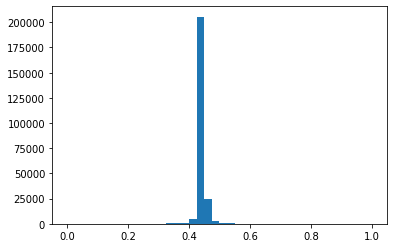

In [18]:
plt.hist(Y_train[:, 0], bins = 40)

(array([1.00000e+00, 0.00000e+00, 2.00000e+00, 3.00000e+00, 3.00000e+00,
        3.00000e+00, 6.00000e+00, 1.30000e+01, 9.00000e+00, 1.60000e+01,
        1.70000e+01, 1.70000e+01, 3.50000e+01, 3.30000e+01, 7.90000e+01,
        1.08000e+02, 2.09000e+02, 2.49000e+02, 5.31700e+03, 5.41520e+04,
        1.76315e+05, 5.72600e+03, 1.19000e+02, 4.80000e+01, 4.10000e+01,
        2.50000e+01, 3.20000e+01, 2.20000e+01, 2.00000e+01, 1.40000e+01,
        1.20000e+01, 7.00000e+00, 1.60000e+01, 8.00000e+00, 8.00000e+00,
        6.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.00534759, 0.0302139 , 0.05508021, 0.07994652, 0.10481283,
        0.12967914, 0.15454545, 0.17941176, 0.20427807, 0.22914439,
        0.2540107 , 0.27887701, 0.30374332, 0.32860963, 0.35347594,
        0.37834225, 0.40320856, 0.42807487, 0.45294118, 0.47780749,
        0.5026738 , 0.52754011, 0.55240642, 0.57727273, 0.60213904,
        0.62700535, 0.65187166, 0.67673797, 0.70160428, 0.72647059,
      

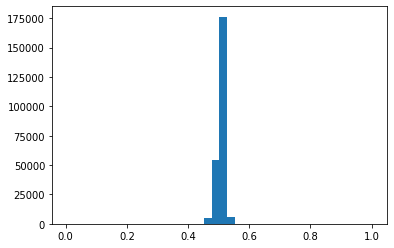

In [19]:
plt.hist(Y_train[:, 1], bins = 40)

(array([2.94000e+02, 2.41000e+02, 2.76000e+02, 1.81000e+02, 1.43000e+02,
        1.11000e+02, 8.30000e+01, 8.00000e+01, 9.30000e+01, 1.66000e+02,
        1.35000e+02, 1.16000e+02, 1.72000e+02, 2.20000e+02, 4.09000e+02,
        6.24000e+02, 1.03700e+03, 2.12700e+03, 5.38700e+03, 6.74050e+04,
        1.49206e+05, 6.14700e+03, 2.59400e+03, 1.37700e+03, 8.20000e+02,
        4.34000e+02, 2.55000e+02, 1.94000e+02, 1.34000e+02, 1.44000e+02,
        1.23000e+02, 1.21000e+02, 1.10000e+02, 1.14000e+02, 1.32000e+02,
        2.13000e+02, 2.75000e+02, 3.56000e+02, 3.46000e+02, 3.01000e+02]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <a list of 40 Patch objects>)

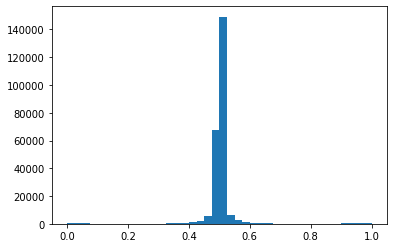

In [20]:
plt.hist(Y_train[:, 2], bins = 40)

In [21]:
np.mean(Y_train, axis = 0)

array([0.4466704 , 0.50179165, 0.50129693])

In [22]:
np.mean(Y_train * (y_max - y_min) + y_min, axis = 0)

array([-4.05163017e-01, -8.24806288e+01,  1.62931364e-02])

In [23]:
# ts_start and ts_end are integers: minute index
state_dim = [2 * half_x_length + 1, 2 * half_y_length + 1, 2 * half_z_length + 1]
def test_timestep_predictions(ts_start, ts_end):
    X, Y = get_X_Y(flight_data, [i for i in range(0, 11)])
    keys = list(X.keys())
    X = [X[key] for key in keys]
    X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
    Y = [Y[key] for key in keys]
    Y = np.array(Y)
    Y_actual = ((np.array(Y) - y_min)/(y_max - y_min))
    X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
    Y_pred = get_predicted_action(sess, mlp, X)
    Y_pred_transformed = Y_pred * (y_max - y_min) + y_min
    loss = get_loss(sess, mlp, X, Y_actual)
    Y_pred = {keys[i]: Y_pred[i, :] for i in range(len(keys))}
    Y_pred_transformed = {keys[i]: Y_pred_transformed[i, :] for i in range(len(keys))}
    return Y_pred, Y_pred_transformed, loss

Y_pred, Y_pred_transformed, loss = test_timestep_predictions(0, 10)

In [24]:
Y_pred

{(0, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (1, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (2, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (3, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (4, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (5, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (6, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (6, 'AB128D_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (7, 'A79F25_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (7, 'AA1949_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (7, 'AB128D_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (8, 'A0312D_0'): array([0.43952274, 0.49671006, 0.47517362], dtype=float32),
 (8, 'A04E0E_0'): array([0.43952274, 0.49671006, 0.47517362], dt

In [25]:
# def simulate_timestep_predictions(ts_start, ts_end):
#     X, Y = get_X_Y([ts_start])
#     keys = list(X.keys())
#     X = [X[key] for key in keys]
#     X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
#     Y = [Y[key] for key in keys]
#     Y = np.array(Y)
#     Y_actual = ((np.array(Y) - y_min)/(y_max - y_min))
#     X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
#     Y_pred = get_predicted_action(sess, mlp, X)
#     Y_pred_transformed = Y_pred * (y_max - y_min) + y_min
#     loss = get_loss(sess, mlp, X, Y_actual)
#     Y_pred = {keys[i]: Y_pred[i, :] for i in range(len(keys))}
#     Y_pred_transformed = {keys[i]: Y_pred_transformed[i, :] for i in range(len(keys))}
#     ts_df = flight_data[flight_data['ts'] == ts_start]
#     for key in Y_pred_transformed.keys():
#         distance = ts_df[ts_df['id'] == key[1]]['speed'] * 60 * 4.63 / 9 # metres
#         lat, lon = destination(ts_df[ts_df['id'] == key[1]]['lat'], ts_df[ts_df['id'] == key[1]]['lon'], ts_df[ts_df['id'] == key[1]]['azimuth'], distance)
#         speed = ts_df[ts_df['id'] == key[1]]['speed'] + Y_pred_transformed[key][0]
#         altitude = ts_df[ts_df['id'] == key[1]]['altitude'] + Y_pred_transformed[key][1]
#         heading = ts_df[ts_df['id'] == key[1]]['heading'] + Y_pred_transformed[key][2]

# Y_pred, Y_pred_transformed_loss = simulate_timestep_predictions(0, 10)

In [26]:
def simulate_timestep_predictions(flight_data, ts_start, ts_end):
    for ts in range(ts_start, ts_end + 1):
        X, Y = get_X_Y(flight_data, [ts])
        keys = list(X.keys())
        X = [X[key] for key in keys]
        X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
        Y = [Y[key] for key in keys]
        Y = np.array(Y)
        Y_actual = ((np.array(Y) - y_min)/(y_max - y_min))
        X = np.concatenate([x.reshape((1, 8250)) for x in X], axis = 0)
        Y_pred = get_predicted_action(sess, mlp, X)
        Y_pred_transformed = Y_pred * (y_max - y_min) + y_min
        loss = get_loss(sess, mlp, X, Y_actual)
        Y_pred = {keys[i]: Y_pred[i, :] for i in range(len(keys))}
        Y_pred_transformed = {keys[i]: Y_pred_transformed[i, :] for i in range(len(keys))}
        ts_df = flight_data[flight_data['ts'] == ts]
        # if ts == ts_start:
        for key in Y_pred_transformed.keys():
            distance = ts_df[ts_df['id'] == key[1]]['ground_speed'].iloc[0] * 60 * 4.63 / 9 # metres
            lat, lon = destination(ts_df[ts_df['id'] == key[1]]['lat'].iloc[0], ts_df[ts_df['id'] == key[1]]['lon'].iloc[0], ts_df[ts_df['id'] == key[1]]['azimuth'].iloc[0], distance)
            speed = ts_df[ts_df['id'] == key[1]]['ground_speed'].iloc[0] + Y_pred_transformed[key][0]
            altitude = ts_df[ts_df['id'] == key[1]]['altitude'].iloc[0] + Y_pred_transformed[key][1]
            heading = ts_df[ts_df['id'] == key[1]]['azimuth'].iloc[0] + Y_pred_transformed[key][2]
            
            # Updating values of next time steps
            flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'ground_speed'] = speed
            flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'altitude'] = altitude
            flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'azimuth'] = (heading % (2*math.pi))
            flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'lat'] = lat
            flight_data.loc[(flight_data['ts'] == (key[0]+1)) & (flight_data['id'] == key[1]), 'lon'] = lon
        
        flight_data['x'] = (x_length * (flight_data['lat'] - lat_min - 0.0001)/(lat_max - lat_min)).apply(math.ceil)
        flight_data['y'] = (y_length * (flight_data['lon'] - lon_min - 0.0001)/(lon_max - lon_min)).apply(math.ceil)
        flight_data['z'] = (flight_data['altitude']/alt_bucket_range).apply(math.floor)
        # Dead aircraft: out of x range, y range or z range
        exit_aircraft = flight_data[(flight_data['ts'] == (ts+1)) & ((flight_data['x'] < 0) | (flight_data['x'] >= x_length) | (flight_data['y'] < 0) | (flight_data['y'] >= y_length))]
        crashed = flight_data[(flight_data['ts'] == (ts+1)) & (flight_data['z'] < 0) | (flight_data['z'] >= z_length) | (flight_data['altitude'] < 0) & ((flight_data['lat'] < 40) | (flight_data['lat'] > 41.25) | (flight_data['lon'] < -74.375) | (flight_data['lon'] > -73.125))]
        remove_ids = set(exit_aircraft['id'].tolist() + crashed['id'].tolist())
        flight_data = flight_data[flight_data['id'].apply(lambda x: not(x in remove_ids))]
        print((ts, exit_aircraft.shape[0], crashed.shape[0]))


# else:
#     

In [27]:
simulate_timestep_predictions(flight_data, 0, 10)

(0, 0, 2)


/home/atc/anaconda3/envs/tf/lib/python3.7/site-packages/pandas-0.24.2-py3.7-linux-x86_64.egg/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/atc/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/atc/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(5, 0, 0)
(6, 0, 0)
(7, 0, 0)
(8, 2, 2)
(9, 0, 5)
(10, 0, 6)


# Conclusion

- All predictions correspond to average (almost no action)
- Forecasting using the model leads to several aircraft crashes